In [1]:
from IPython.display import display
import os

# 上傳檔案（會跳出檔案選擇器）
from ipywidgets import FileUpload

upload = FileUpload()
display(upload)

FileUpload(value=(), description='Upload')

In [2]:
import os
from pathlib import Path

# 假設你只上傳了一個檔案
fileinfo = upload.value[0]  # 通常是一個 dict，含 'name' 和 'content'

# 顯示內容結構（除錯用）
print(fileinfo)

# 儲存 kaggle.json
filename = fileinfo['name']
content = fileinfo['content']

kaggle_dir = Path.home() / ".kaggle"
kaggle_dir.mkdir(exist_ok=True)

kaggle_json_path = kaggle_dir / "kaggle.json"
with open(kaggle_json_path, "wb") as f:
    f.write(content)

# 設定權限（Linux/macOS 建議）
os.chmod(kaggle_json_path, 0o600)

print(f"{filename} 已成功儲存至 {kaggle_json_path}")

{'name': 'kaggle.json', 'type': 'application/json', 'size': 64, 'content': <memory at 0x76af01674d00>, 'last_modified': datetime.datetime(2025, 4, 21, 6, 7, 11, 972000, tzinfo=datetime.timezone.utc)}
kaggle.json 已成功儲存至 /home/jovyan/.kaggle/kaggle.json


In [3]:
!kaggle datasets list -s cifar


/bin/bash: line 1: kaggle: command not found


In [4]:
!pip install -U kaggle
!pip install --upgrade pandas
import os
import zipfile

# 建立 Kaggle 資料夾
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 下載 Dog Breed Identification 資料集
!kaggle competitions download -c dog-breed-identification --force
!unzip -oq dog-breed-identification.zip -d dog-breed-identification


import pandas as pd
import numpy as np

labels = pd.read_csv('dog-breed-identification/labels.csv')


  Using cached kaggle-1.7.4.5-py3-none-any.whl (181 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)
  Using cached python_slugify-8.0.4-py2.py3-none-any.whl (10 kB)
  Using cached pandas-2.2.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
  Attempting uninstall: tzdata
    Found existing installation: tzdata 2022.4
    Uninstalling tzdata-2022.4:
      Successfully uninstalled tzdata-2022.4
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.0
    Uninstalling pandas-1.5.0:
      Successfully uninstalled pandas-1.5.0
cp: cannot stat 'kaggle.json': No such file or directory
100%|████████████████████████████████████████▉| 690M/691M [00:04<00:00, 162MB/s]
100%|█████████████████████████████████████████| 691M/691M [00:04<00:00, 155MB/s]


/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
import os
import shutil
import pandas as pd
from PIL import Image
from tqdm import tqdm
# 讀取標籤
labels = pd.read_csv('dog-breed-identification/labels.csv')
# 建立目標輸出資料夾
output_dir = "dog_images"
train_dir = os.path.join(output_dir, "train")
os.makedirs(train_dir, exist_ok=True)

# 根據標籤將圖片存入對應資料夾
def organize_train_images(labels): # Pass labels as an argument
    src_img_dir = "dog-breed-identification/train"
    for idx, row in tqdm(labels.iterrows(), total=len(labels)):
        img_id = row['id']
        breed = row['breed']
        src_path = os.path.join(src_img_dir, img_id + ".jpg")

        # 建立品種對應資料夾
        breed_dir = os.path.join(train_dir, breed)
        os.makedirs(breed_dir, exist_ok=True)

        dst_path = os.path.join(breed_dir, img_id + ".jpg")
        shutil.copyfile(src_path, dst_path)

# Load labels outside the function
labels = pd.read_csv('dog-breed-identification/labels.csv')
organize_train_images(labels) # Call the function with labels argument

100%|██████████| 10222/10222 [01:07<00:00, 151.39it/s]


In [6]:
!pip install timm

  Using cached timm-1.0.15-py3-none-any.whl (2.4 MB)
  Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (471 kB)


In [7]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from tqdm import tqdm
import timm

from torch.optim.lr_scheduler import CosineAnnealingLR


In [8]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def cutmix_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    y_a, y_b = y, y[index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    return x, y_a, y_b, lam

def criterion_mixup(pred, y_a, y_b, lam):
    return lam * F.cross_entropy(pred, y_a) + (1 - lam) * F.cross_entropy(pred, y_b)


In [9]:
 #自定義 Dataset 類別
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

from PIL import UnidentifiedImageError
class DogBreedImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # 建立類別對應表：品種 → 數值 label
        class_names = sorted(os.listdir(root_dir))
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

        for class_name in class_names:
            class_folder = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_folder):
                continue
            for filename in os.listdir(class_folder):
                if filename.endswith(('.jpg', '.png')):
                    self.image_paths.append(os.path.join(class_folder, filename))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert("RGB")
        except UnidentifiedImageError:
            print(f"Cannot open image: {img_path}")
            return self.__getitem__((idx + 1) % len(self.image_paths))  # 嘗試下一張

        if self.transform:
            image = self.transform(image)
    
        return image, label

In [10]:
# 定義 Transform
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip, ColorJitter, RandomRotation, ToTensor, Normalize

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [11]:
# 建立 Dataset 與切分
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler
import collections
from collections import Counter

# 讀取分類後資料
dataset = DogBreedImageFolder("dog_images/train", transform=train_transform)

# 計算資料數量與切分比例
val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 取得 training set 的原始 indices
train_indices = train_dataset.indices  # 是 dataset 中對應的索引
train_labels = [dataset.labels[i] for i in train_indices]

# 計算類別樣本數與每個 sample 權重
label_counts = Counter(train_labels)
class_sample_counts = [label_counts[i] for i in range(len(label_counts))]
sample_weights = [1.0 / class_sample_counts[label] for label in train_labels]

# 建立 WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# 顯示類別分布（驗證分布仍可看是否合理）
val_labels = [dataset.labels[i] for i in val_dataset.indices]
print("Train label distribution:", Counter(train_labels))
print("Val label distribution:", Counter(val_labels))


Train label distribution: Counter({97: 101, 73: 97, 1: 93, 94: 93, 11: 92, 7: 91, 42: 90, 87: 90, 3: 89, 26: 89, 9: 86, 75: 86, 109: 86, 52: 86, 6: 86, 100: 85, 88: 82, 61: 82, 13: 80, 84: 79, 59: 79, 69: 79, 60: 78, 2: 78, 68: 78, 101: 78, 70: 78, 117: 76, 93: 76, 102: 75, 80: 75, 56: 74, 86: 74, 30: 74, 98: 74, 10: 73, 17: 73, 35: 73, 63: 72, 19: 72, 20: 72, 114: 71, 95: 71, 78: 71, 90: 71, 37: 68, 39: 68, 92: 68, 74: 68, 50: 67, 82: 67, 119: 67, 62: 67, 55: 67, 64: 66, 40: 66, 28: 66, 67: 66, 21: 66, 57: 66, 118: 65, 96: 65, 14: 65, 79: 65, 76: 65, 71: 65, 104: 64, 116: 64, 8: 64, 33: 64, 81: 64, 5: 63, 110: 63, 115: 63, 4: 63, 31: 63, 53: 63, 25: 62, 77: 62, 111: 62, 15: 62, 54: 61, 27: 61, 107: 61, 12: 61, 18: 60, 105: 60, 36: 60, 38: 60, 0: 60, 103: 59, 72: 59, 83: 59, 51: 59, 91: 59, 58: 58, 16: 58, 113: 58, 85: 57, 112: 57, 99: 57, 24: 57, 41: 57, 89: 56, 47: 56, 44: 56, 106: 56, 65: 56, 66: 56, 32: 56, 48: 55, 46: 55, 23: 54, 34: 54, 22: 53, 45: 52, 49: 51, 43: 51, 29: 48, 108

In [12]:
#驗證資料載入
# 驗證一個 batch
for images, labels in train_loader:
    print("Images shape:", images.shape)  # [B, 3, 224, 224]
    print("Labels shape:", labels.shape)  # [B]
    break

Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


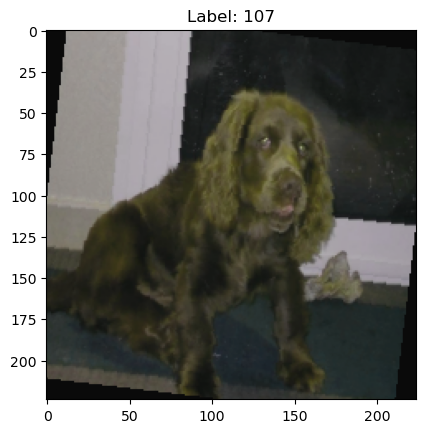

In [13]:
# 如果需要視覺化一個 batch
import matplotlib.pyplot as plt
def show_batch(loader):
    images, labels = next(iter(loader))
    img = images[0].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(f"Label: {labels[0]}")
    plt.show()

show_batch(train_loader)

In [14]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()


In [15]:
import torch
import torch.nn as nn
import torchvision.models as models

num_classes = 120  # Dog Breed Identification 有 120 類別
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import timm

# timm 中的 xception 模型，使用預訓練權重
model = timm.create_model('xception', pretrained=True, num_classes=num_classes)


# 搬移到裝置（GPU 或 CPU）
model = model.to(device)

/opt/conda/lib/python3.9/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [16]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR
num_epochs = 30
# 1. 計算 class weights（根據整體 dataset 分布）
from collections import Counter

label_counts = Counter(dataset.labels)
num_classes = 120
class_counts = [label_counts[i] for i in range(num_classes)]

# 權重：類別樣本越少，損失權重越高
weights = [1.0 / c for c in class_counts]
weights = torch.tensor(weights, dtype=torch.float).to(device)

# 2. 使用 CrossEntropy + class weights + label smoothing
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=30)

In [17]:
for epoch in range(30):
    model.train()
    total_loss = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        r = np.random.rand()
        if r < 0.5:
            images, y_a, y_b, lam = mixup_data(images, labels)
        else:
            images, y_a, y_b, lam = cutmix_data(images, labels)

        preds = model(images)
        loss = criterion_mixup(preds, y_a, y_b, lam)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")
    scheduler.step()


100%|██████████| 256/256 [00:59<00:00,  4.29it/s]


Epoch 1, Loss: 4.23084210138768


100%|██████████| 256/256 [00:58<00:00,  4.39it/s]


Epoch 2, Loss: 3.442881322465837


100%|██████████| 256/256 [00:58<00:00,  4.36it/s]


Epoch 3, Loss: 3.259571694303304


100%|██████████| 256/256 [00:59<00:00,  4.33it/s]


Epoch 4, Loss: 3.0191421904601157


100%|██████████| 256/256 [00:58<00:00,  4.36it/s]


Epoch 5, Loss: 2.9222552087157965


100%|██████████| 256/256 [00:58<00:00,  4.35it/s]


Epoch 6, Loss: 2.7764413645491004


100%|██████████| 256/256 [00:59<00:00,  4.33it/s]


Epoch 7, Loss: 2.6279203488957137


100%|██████████| 256/256 [00:59<00:00,  4.28it/s]


Epoch 8, Loss: 2.5001756586134434


100%|██████████| 256/256 [01:01<00:00,  4.18it/s]


Epoch 9, Loss: 2.3830713178031147


100%|██████████| 256/256 [00:58<00:00,  4.37it/s]


Epoch 10, Loss: 2.291793682379648


100%|██████████| 256/256 [01:00<00:00,  4.24it/s]


Epoch 11, Loss: 2.306428049108945


100%|██████████| 256/256 [00:58<00:00,  4.37it/s]


Epoch 12, Loss: 2.1888263463042676


100%|██████████| 256/256 [01:01<00:00,  4.19it/s]


Epoch 13, Loss: 2.1717399795306846


100%|██████████| 256/256 [00:58<00:00,  4.38it/s]


Epoch 14, Loss: 2.0795442685484886


100%|██████████| 256/256 [01:01<00:00,  4.18it/s]


Epoch 15, Loss: 2.160731809679419


100%|██████████| 256/256 [00:58<00:00,  4.38it/s]


Epoch 16, Loss: 2.05443805817049


100%|██████████| 256/256 [00:58<00:00,  4.38it/s]


Epoch 17, Loss: 1.9821957108797505


100%|██████████| 256/256 [00:58<00:00,  4.38it/s]


Epoch 18, Loss: 1.889989561517723


100%|██████████| 256/256 [00:58<00:00,  4.37it/s]


Epoch 19, Loss: 1.7981503648334183


100%|██████████| 256/256 [00:58<00:00,  4.37it/s]


Epoch 20, Loss: 1.7891390302684158


100%|██████████| 256/256 [00:58<00:00,  4.35it/s]


Epoch 21, Loss: 1.8370256526395679


100%|██████████| 256/256 [00:58<00:00,  4.35it/s]


Epoch 22, Loss: 1.7921842046780512


100%|██████████| 256/256 [00:58<00:00,  4.36it/s]


Epoch 23, Loss: 1.82477543578716


100%|██████████| 256/256 [00:58<00:00,  4.34it/s]


Epoch 24, Loss: 1.7095801633549854


100%|██████████| 256/256 [00:58<00:00,  4.36it/s]


Epoch 25, Loss: 1.8362999719247455


100%|██████████| 256/256 [00:58<00:00,  4.36it/s]


Epoch 26, Loss: 1.7119728821562603


100%|██████████| 256/256 [00:58<00:00,  4.36it/s]


Epoch 27, Loss: 1.7000054761301726


100%|██████████| 256/256 [00:58<00:00,  4.37it/s]


Epoch 28, Loss: 1.6693185384501703


100%|██████████| 256/256 [00:58<00:00,  4.35it/s]


Epoch 29, Loss: 1.6927538302261382


100%|██████████| 256/256 [00:58<00:00,  4.35it/s]

Epoch 30, Loss: 1.6867473493912257


In [18]:
# 保存訓練後的模型
torch.save(model.state_dict(), "dog_breed_model.pth")


In [19]:
# 測試集的評估
test_accuracy = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        test_accuracy += (predicted == labels).sum().item()

test_accuracy = 100 * test_accuracy / len(val_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}%")

import os

Test Accuracy: 70.84%


In [20]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class TestImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_filenames = sorted(os.listdir(image_folder))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name.split('.')[0]  # 傳回 image tensor 和 id（

In [21]:
# 取得所有類別名稱，需排序以符合 submission 格式
all_breeds = sorted(dataset.class_to_idx.keys())

# 建立 mapping
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
# 修正 Test transform 使用與訓練相同的 ImageNet 格式
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),  # 與訓練相同
                         (0.229, 0.224, 0.225))
])


# 設定測試資料夾路徑
test_folder = 'dog-breed-identification/test'  # 請確認實際位置

# 建立 DataLoader
test_dataset = TestImageDataset(test_folder, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 建立 DataFrame 儲存預測結果
results = []

In [22]:
# 定義 TTA transform 列表（3種不同版本）
tta_transforms = [
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ]),
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=1.0),  # 強制翻轉
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ]),
    transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ])
]

import torch.nn.functional as F

results = []

model.eval()
with torch.no_grad():
    for images, image_ids in test_loader:
        images = images.to(device)

        # 初始化所有樣本的 logits 累加
        all_logits = torch.zeros((images.size(0), num_classes), device=device)

        # TTA 多次預測，平均 softmax 結果
        for tta_transform in tta_transforms:
            tta_images = []
            for image in images:
                pil_img = transforms.ToPILImage()(image.cpu())
                tta_image = tta_transform(pil_img)
                tta_images.append(tta_image)
            tta_images = torch.stack(tta_images).to(device)
            logits = model(tta_images)
            all_logits += F.softmax(logits, dim=1)  # 使用 softmax 而非 raw logits

        # 平均 softmax 分數
        avg_probs = all_logits / len(tta_transforms)

        for img_id, probs in zip(image_ids, avg_probs.cpu()):
            row = {"id": img_id}
            for b, p in zip(all_breeds, probs):
                row[b] = p.item()
            results.append(row)

# 儲存為 soft label CSV 檔
df = pd.DataFrame(results)
df.to_csv("submission4_tta.csv", index=False)
print("✅ 使用 softmax 的 TTA 版本 submission4_tta.csv 轉換完成，可上傳 Kaggle！")


✅ 使用 softmax 的 TTA 版本 submission4_tta.csv 轉換完成，可上傳 Kaggle！
